Revised Incrementality Model

In [14]:
#!pip install pmdarima
# !pip install openpyxl
# !pip install ast
"""
Importing all libraries to execute code
"""


# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Basic imports
import os
import time
import json
import ast
import pickle
import itertools
import numpy as np
import pandas as pd
from datetime import datetime

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.dates import date2num
from matplotlib.ticker import FuncFormatter
import seaborn as sns
%matplotlib inline

# Statistics
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Prophet (Time Series Forecasting)
import prophet as Prophet

# Time Series Analysis
from pmdarima import auto_arima

# Machine Learning: XGBoost
import xgboost as xgb
from xgboost.sklearn import XGBRegressor  # Wrapper
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Excel File Manipulation
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import openpyxl

# Data Profiling
from dataprofiler import Profiler, Data

# Custom Function (from original code block)
def millions(x, pos):
    return f'{x * 1e-6:.1f}M'

# **Rossman Store Sales Data**

**Rossmann**, is one of the largest drugstore chains in Europe, headquartered in Burgwedel, Germany. Founded in 1972 by Dirk Rossmann, the company has grown significantly and operates over 4,700 stores across several countries, including Germany, Poland, Hungary, the Czech Republic, Albania, Turkey, Kosovo, and Spain.

In **2015**, Rossman held a competition on <a href =https://www.kaggle.com/competitions/rossmann-store-sales/overview >Kaggle</a>. They uploaded sales data along with auxillary information for over **1000** stores, with the aim of finding submissions from competitors who develop the best model that fit sales and forecast the next 6 weeks of sales. 

The competition was evaluated on Root Mean Square Percentage error (RMSPE). Calculated as:
$$
\text{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left( \frac{y_i - \hat{y}_i}{y_i} \right)^2}
$$

**Where:**

$$
y_i \text{ is the actual (observed) value for the } i\text{-th data point,}
$$

$$
\hat{y}_i \text{ is the predicted value for the } i\text{-th data point,}
$$

$$
n \text{ is the total number of data points in the dataset.}
$$

#### Dataset

The dataset provided is constituted of 3 files:
- **Train** - This includes sales data for 1,115 stores. With granularity of **Sales per Day per Store**.
- **Test** - This includes sales data for 1,115 stores. With granularity of **Sales per Day per Store**.
- **Store** - This dataset has auxillary data.

In [5]:
# importing train data to learn
train = pd.read_csv("train.csv", 
                    parse_dates = True, index_col = 'Date')

# additional store data
store = pd.read_csv("store.csv")
# time series as indexes
# dataTypeAnalyze = Data("train.csv")
# profile = Profiler(dataTypeAnalyze)

# human_readable_report = profile.report(report_options={"output_format":"pretty"})

# print(json.dumps(human_readable_report, indent=4))
display(train)
display(store)


# for column in train.columns:
#     unique_values = train[column].unique()
#     print(f"Unique values in column '{column}': {unique_values}")
# print(train.shape)

# for column in store.columns:
#     unique_values = store[column].unique()
#     print(f"Unique values in column '{column}': {unique_values}")
# print(store.shape)

/var/folders/nl/z3gczdxx3030h6c4wb6vrr4m0000gn/T/ipykernel_49801/2787223949.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv",


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


#### **Train Feature Descriptions**

This table provides an overview of the key features and their descriptions:

| **Feature**         | **Description**                                                                                   |
|----------------------|---------------------------------------------------------------------------------------------------|
| **Sales**           | The turnover for any given day (target variable).                                                 |
| **Customers**       | The number of customers on a given day.                                                           |
| **Open**            | Indicates whether the store was open: **0** = closed, **1** = open.                               |
| **Promo**           | Indicates whether a store was running a promotion on that day.                                    |
| **StateHoliday**    | Indicates a state holiday. Normally, all stores, with few exceptions, are closed on state holidays. |
| **SchoolHoliday**   | Indicates if the store was affected by the closure of public schools on that day.                 |

---

##### **Notes**
- **Sales** is the target variable in this dataset.
- Features like **StateHoliday** and **SchoolHoliday** provide contextual information about external factors affecting the store's operations.
- **Open** is a binary indicator that tells whether the store was operating on a given day.

#### **Store Feature Descriptions**

This table provides detailed information about the features in the dataset:

| **Feature**                      | **Description**                                                                                                              |
|----------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| **Store**                        | A unique ID for each store.                                                                                                   |
| **StoreType**                    | Differentiates between 4 different store models: **a**, **b**, **c**, **d**.                                                  |
| **Assortment**                   | Describes the assortment level: **a** = basic, **b** = extra, **c** = extended.                                               |
| **CompetitionDistance**          | Distance in meters to the nearest competitor store.                                                                           |
| **CompetitionOpenSince[Month/Year]** | Gives the approximate year and month when the nearest competitor store was opened.                                             |
| **Promo2**                       | Indicates if the store is participating in a continuing promotion: **0** = not participating, **1** = participating.          |
| **Promo2Since[Year/Week]**       | Describes the year and calendar week when the store started participating in Promo2.                                           |
| **PromoInterval**                | Describes the months when Promo2 starts. For example, **"Feb, May, Aug, Nov"** means Promo2 begins in these months annually.  |

---

##### **Notes**
- **StoreType** and **Assortment** provide categorical details about the type of store and the variety of products offered.
- **CompetitionDistance** and **CompetitionOpenSince** offer insights into how competition impacts sales.
- **Promo2** and related features (**Promo2Since** and **PromoInterval**) describe ongoing promotional activities that vary across stores.
- These features are used to analyze store performance and customer behavior across different contexts.

#### **We will now do some data cleaning/wrangling and visualize the data**


In [7]:
print("The data runs over ", train.index.nunique(), "days")
print("The unique number of stores ", train['Store'].nunique())


# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week 

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']

The data runs over  942 days
The unique number of stores  1115


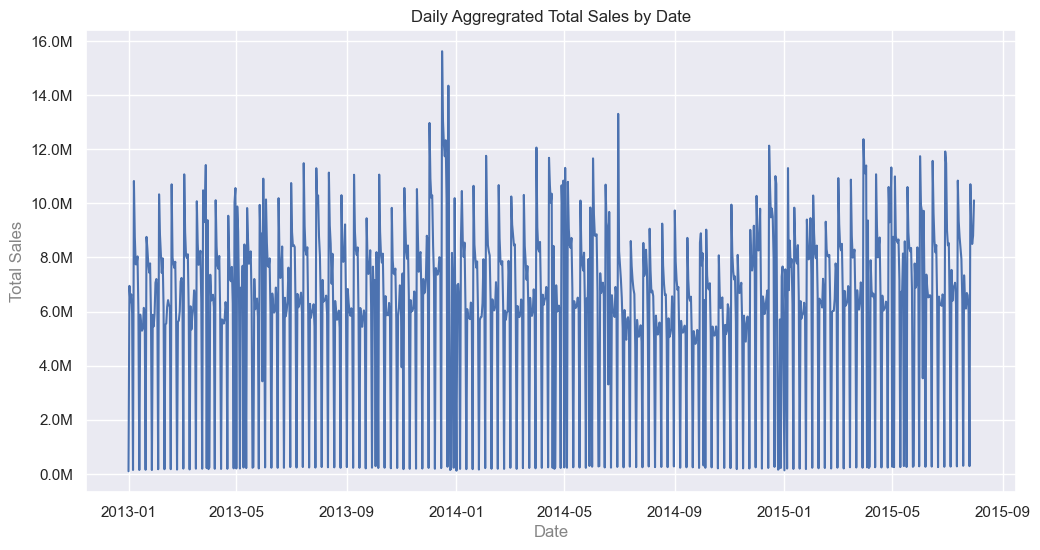

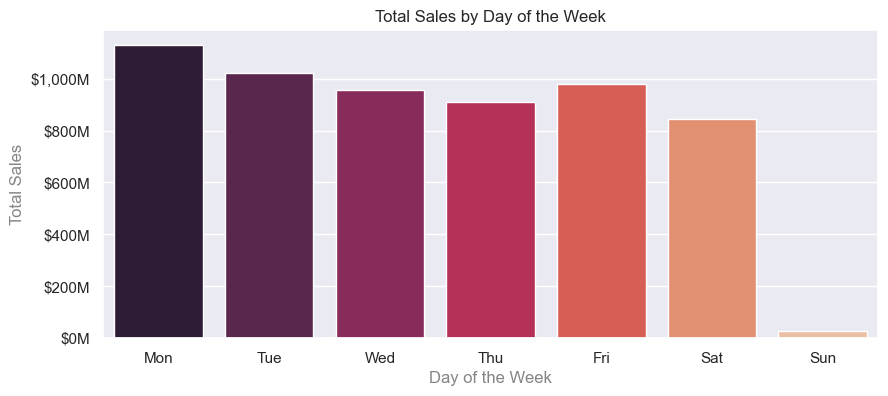

In [35]:
train_aggregated = train.groupby(train.index).agg(
    Total_Sales=('Sales', 'sum'),
    Total_Customers=('Customers', 'sum')
)
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data


# Plot the responses for different events and regions
# Reuse to format timeseries graphs -----------------
plt.figure(figsize=(12,6))
plt.ylabel("Total Sales",color = '#858585')
plt.xlabel("Date",color = '#858585')
formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title("Daily Aggregrated Total Sales by Date")
#--------------
sns.lineplot(x="Date", y="Total_Sales",
           
             data=train_aggregated)

train['DayOfWeek'] = train.index.dayofweek  # 0 = Monday, 6 = Sunday

# Aggregate sales by DayOfWeek
sales_by_dow = train.groupby('DayOfWeek')['Sales'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 4))
sns.barplot(x='DayOfWeek', y='Sales', data=sales_by_dow, palette='rocket')

# Add labels and title
# Reuse to format timeseries graphs -----------------

plt.ylabel("Total Sales",color = '#858585')
plt.xlabel("Date",color = '#858585')

#--------------
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.title('Total Sales by Day of the Week')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x*1e-6:,.0f}M'))
# Show the plot
plt.show()


# **Explatory Data Analysis (EDA)**

Displaying the data we can see a following interesting features from the sales data. Primarily:
- **Seasonality** 

    - ***Yearly*** - We can see seasonality between the start and end of the calendar year.
    - ***Weekly*** - We can also see weekly seasonality, with sales peaking on Mondays, and troughs on Sundays. [As shown in the graph above]
- **Cycles** - The data exhibits rises and falls that aren't neccassarily fixed in frequency. Often related to business cycles. This is most likely due to promotions.
- **Troughs** - Noticeable points where sales drop to zero, likely indicating days when stores were closed (e.g., holidays or operational breaks).


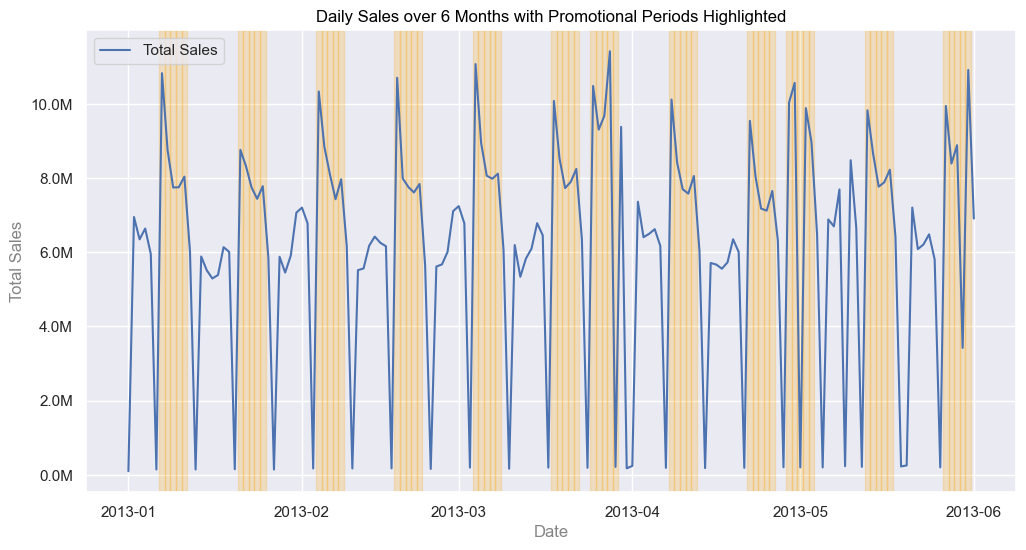

In [40]:
sales= (
    train
    .groupby([train.index, 'Promo'])  # Group by index and Promo
    .agg({
        'Sales': 'sum',          # Sum "Sales"
        'Customers': 'sum'       # Sum "Customers"
    })
)
sales_6_months = sales['2013-01-01':'2013-06-01'].reset_index()


sns.set_theme(style="darkgrid")

# Initialize figure
plt.figure(figsize=(12,6))
plt.ylabel("Total Sales", color='#858585')
plt.xlabel("Date", color='#858585')

# Format y-axis
formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

# Title
plt.title("Daily Sales over 6 Months with Promotional Periods Highlighted", color = 'black',fontweight = 'bold')

# Plot the Sales time series
sns.lineplot(x="Date", y="Sales", data=sales_6_months, label="Total Sales")

# Highlight Promo periods
for _, row in sales_6_months[sales_6_months['Promo'] == 1].iterrows():
    plt.axvspan(row['Date'] - pd.Timedelta(days=0.5), 
                row['Date'] + pd.Timedelta(days=0.5), 
                color='orange', alpha=0.2, label="Promo" if _ == 0 else "")

plt.legend()
plt.show()


# My Model ------------------------------------------------------------------------------------------------------------------------------------------------------------------

           sales        date
0     2074843.60  28/09/2020
1     2087143.78  29/09/2020
2     2530041.66  30/09/2020
3     2708738.05   1/10/2020
4     2275606.10   2/10/2020
...          ...         ...
1303        0.00  23/04/2024
1304        0.00  24/04/2024
1305        0.00  25/04/2024
1306        0.00  26/04/2024
1307        0.00  27/04/2024

[1308 rows x 2 columns]
2020-09-28 00:00:00
2024-01-27 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
                 sales
date                  
2020-09-28  2074843.60
2020-09-29  2087143.78
2020-09-30  2530041.66
2020-10-01  2708738.05
2020-10-02  2275606.10
...                ...
2024-01-23  3290581.91
2024-01-24  3145283.13
2024-01-25  4189974.32
2024-01-26  2628437.30
2024-01-27  4215693.07

[1217 rows x 1 columns]


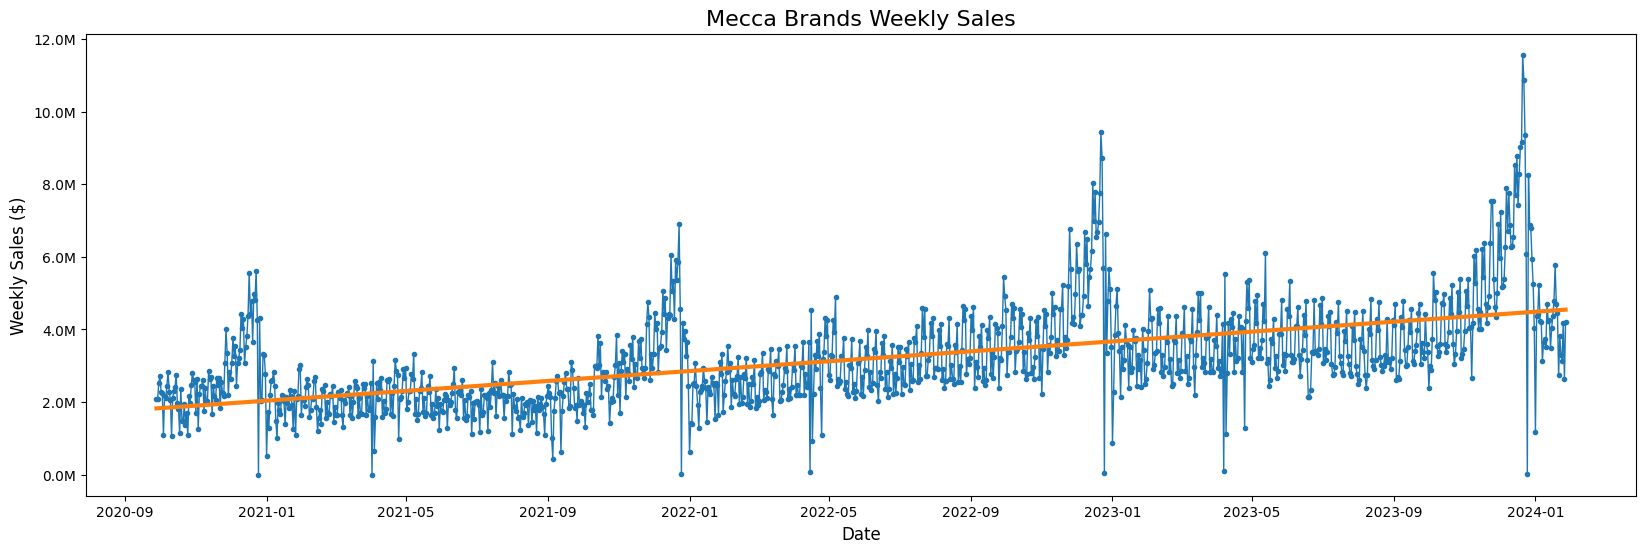

MSE: 1,245,440,292,665.30
RMSE: 1,115,992.96
MAE: 790,671.23
MAPE: inf%
R^2: 0.33


In [2]:
# Pulling sales data and calculating the accuracy of linear model.

df=pd.read_csv('revisedsales2.csv')
data = df.rename(columns={'ty_date': 'date'})
print(data)

data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
#data['date2'] = pd.to_datetime(data['date'])
#data.to_csv('testing.csv',mode='w+')
data = data.set_index('date')
data.index = pd.DatetimeIndex(data.index, freq='D')
#data = data.iloc[: , 1:]
#data=data[1:] #Removed first week because it is incomplete
data.sort_values(by='date', inplace=True)
data=data[:'2024-01-27']
# Resample data on a weekly basis and sum the sales
#data = data.resample('D').sum()
# data.to_clipboard()
print( min(data.index))
print( max(data.index))
#data.to_csv('testing')
print(type(data.index[0]))
print(data)
#plot the sales data!
# print(data['date'])
#x=data.index
#data=data['2021-06-01':]
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

y=data['sales']
x = date2num(data.index.to_pydatetime())
x = x.reshape(-1, 1)  # Reshape for sklearn which expects 2D array for features
y = data['sales'].values



#print(highest_points)
reg= LinearRegression().fit(x,y)
y_pred = reg.predict(x)
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(data.index,y,marker='.', linestyle='-', linewidth=1, label='Weekly')
ax.plot(data.index,y_pred, linestyle='-', linewidth=3, label='Weekly')
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.title('Mecca Brands Weekly Sales',fontsize=16)
plt.ylabel('Weekly Sales ($)',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.show()

y = np.array(y)
mse = mean_squared_error(y, y_pred)

# Calculate RMSE
rmse = mean_squared_error(y, y_pred, squared=False)

# Calculate MAE
mae = mean_absolute_error(y, y_pred)

# Calculate MAPE - Handling division by zero if y contains zeros
mape = np.mean(np.abs((y - y_pred) / y)) * 100 if np.all(y) else float('inf')

# Calculate R^2
r2 = r2_score(y, y_pred)

#Calculate the f1 score

print('MSE: {:,.2f}'.format(mse))
print('RMSE: {:,.2f}'.format(rmse))
print('MAE: {:,.2f}'.format(mae))
print('MAPE: {:.2f}%'.format(mape))  # Percentage values don't typically include commas
print('R^2: {:.2f}'.format(r2))

#print(df.to_string())

In [3]:
exog = pd.read_excel('exogwithdayofweekandcampaigns.xlsx',engine='openpyxl')
exog=exog[['date','campaign','weekend']]
exog['campaign']=exog['campaign'].fillna(0)
exog = exog.set_index('date')
exog.index = pd.DatetimeIndex(exog.index, freq='D')
print(len(exog))
print(type(exog['campaign']))

public_holidays = ['2020-12-25','2021-01-01','2021-12-25','2022-01-01','2022-12-25','2023-01-01','2023-12-25', '2024-01-01','2021-04-02','2021-04-04','2022-04-15','2022-04-17','2023-04-07','2023-04-09']  

# Convert your date column to datetime format if it's not already
#df['date'] = pd.to_datetime(df['date'])
print(exog)
# Create a binary indicator for public holidays
exog['is_public_holiday'] = exog.index.isin(public_holidays).astype(int)
#print(exog.to_string())
print(len(exog))
print(len(y))
#exog.loc[exog.index < '2023-01-01', 'weekend'] = 0


1224
<class 'pandas.core.series.Series'>
            campaign  weekend
date                         
2020-09-21       0.0        0
2020-09-22       0.0        0
2020-09-23       0.0        0
2020-09-24       0.0        1
2020-09-25       0.0        1
...              ...      ...
2024-01-23       0.0        0
2024-01-24       0.0        0
2024-01-25       0.0        1
2024-01-26       0.0        1
2024-01-27       0.0        1

[1224 rows x 2 columns]
1224
1217


In [4]:
#adding in fourier terms to the model.
# seasonality=365
# n=1224
# t=1
# # Create Fourier terms for weekly seasonality
# def create_fourier_terms(t, period, num_terms):
#     terms = []
#     for i in range(1, num_terms + 1):
#         terms.append(np.sin(2 * np.pi * i * t / period))
#         terms.append(np.cos(2 * np.pi * i * t / period))
#     return np.column_stack(terms)

# num_fourier_terms = 4
# fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

def fourier_terms(data, period, K):
    # `data` is the DataFrame, `period` is the seasonal period (e.g., 365 for yearly),
    # and `K` is the number of sine/cosine term pairs
    T = len(data)
    t = np.arange(1, T + 1)
    
    fourier_terms = pd.DataFrame(index=data.index)
    
    for k in range(1, K + 1):
        fourier_terms[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier_terms[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
        
    return fourier_terms
K = 6  # Number of terms; adjust based on your model's needs
period = 365  # Yearly seasonality
fourier_terms_df = fourier_terms(data, period, K)
print(fourier_terms_df)
combined_exog = pd.concat([exog, fourier_terms_df], axis=1)
print(combined_exog)
exog=combined_exog

               sin_1     cos_1     sin_2     cos_2     sin_3     cos_3   
date                                                                     
2020-09-28  0.017213  0.999852  0.034422  0.999407  0.051620  0.998667  \
2020-09-29  0.034422  0.999407  0.068802  0.997630  0.103102  0.994671   
2020-09-30  0.051620  0.998667  0.103102  0.994671  0.154309  0.988023   
2020-10-01  0.068802  0.997630  0.137279  0.990532  0.205104  0.978740   
2020-10-02  0.085965  0.996298  0.171293  0.985220  0.255353  0.966848   
...              ...       ...       ...       ...       ...       ...   
2024-01-23  0.895839 -0.444378 -0.796183 -0.605056 -0.188227  0.982126   
2024-01-24  0.888057 -0.459733 -0.816538 -0.577292 -0.137279  0.990532   
2024-01-25  0.880012 -0.474951 -0.835925 -0.548843 -0.085965  0.996298   
2024-01-26  0.871706 -0.490029 -0.854322 -0.519744 -0.034422  0.999407   
2024-01-27  0.863142 -0.504961 -0.871706 -0.490029  0.017213  0.999852   

               sin_4     cos_4     si

# Mecca Sales Data: Fitting a Linear Regression Model





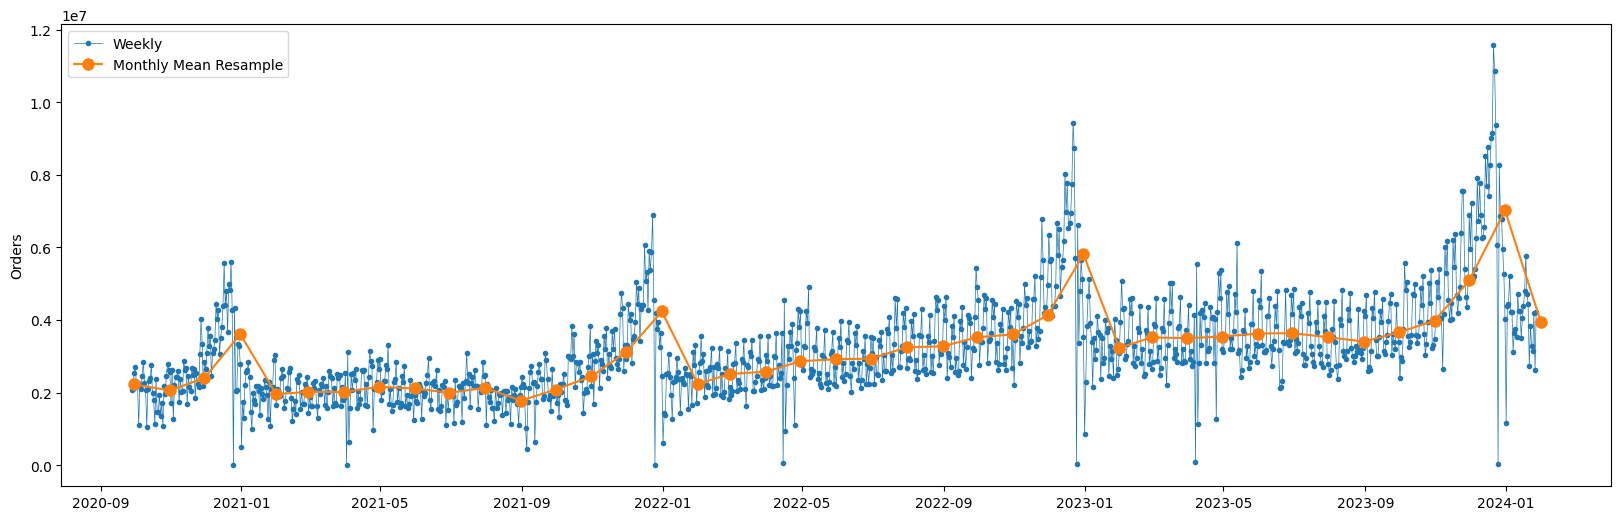

In [5]:
y = data['sales']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend()

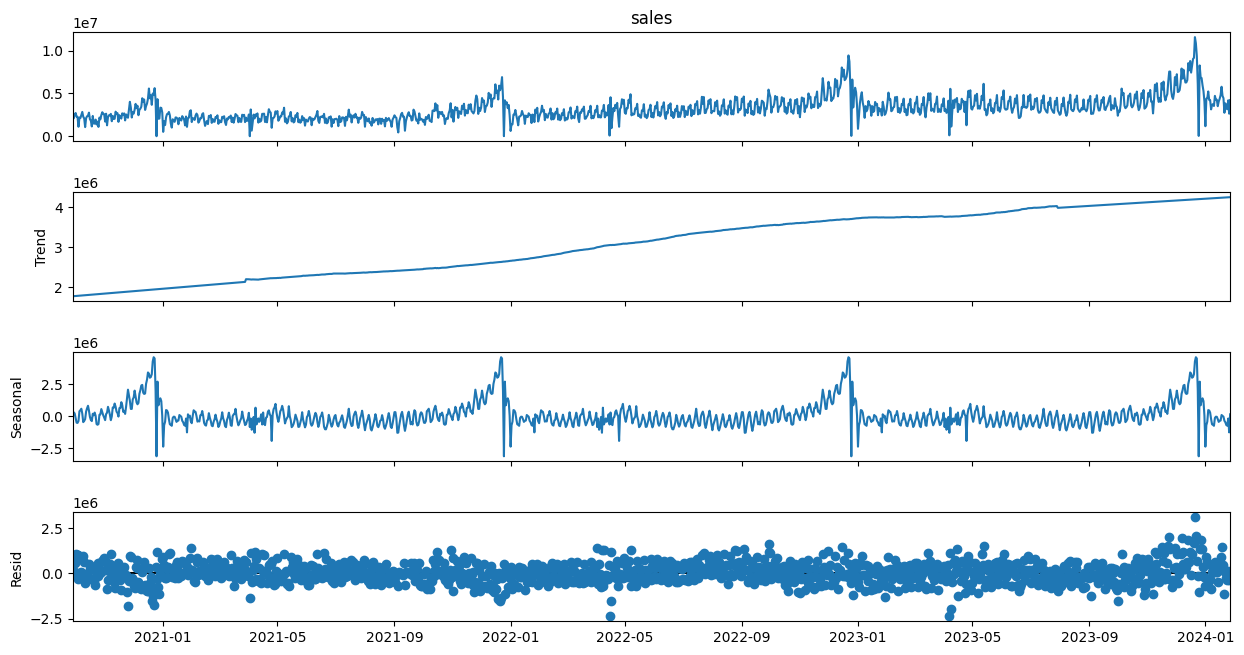

                seasonal
date                    
2020-09-28  1.337815e+05
2020-09-29  2.903945e+05
2020-09-30  1.996189e+05
2020-10-01 -1.639345e+05
2020-10-02 -5.175766e+05
...                  ...
2024-01-23 -7.030045e+05
2024-01-24 -7.541301e+05
2024-01-25 -1.931212e+05
2024-01-26 -1.274952e+06
2024-01-27  1.369103e+05

[1217 rows x 1 columns]


In [6]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq',period=365)
    seasonal = decomposition.seasonal
    seasonal_df = pd.DataFrame(seasonal)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    return seasonal_df
seasonal_df = seasonal_decompose(y)
print(seasonal_df)
seasonal_df.to_csv('MeccaSeasonalIndices.csv')
# def seasonal_decompose_to_df(y):
#     decomposition = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq', period=365)
#     # Decompose the time series
#     seasonal = decomposition.seasonal
#     # Convert the seasonal component to a DataFrame
#     seasonal_df = pd.DataFrame(seasonal)
#     # Plot the decomposition
#     fig = decomposition.plot()
#     fig.set_size_inches(14, 7)
#     plt.show()
#     # Return the DataFrame
#     return seasonal_df

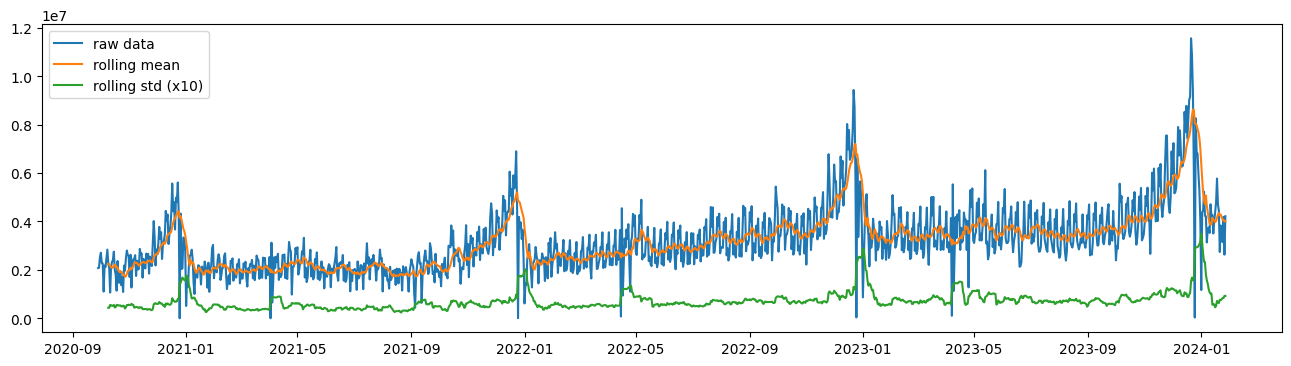

In [7]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [8]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -3.147
P-value = 0.023
Critical values :
	1%: -3.4358340188169882 - The data is not stationary with 99% confidence
	5%: -2.8639616494853217 - The data is  stationary with 95% confidence
	10%: -2.5680593310691338 - The data is  stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -8.680
P-value = 0.000
Critical values :
	1%: -3.4358850794152054 - The data is  stationary with 99% confidence
	5%: -2.8639841761618654 - The data is  stationary with 95% confidence
	10%: -2.568071328096466 - The data is  stationary with 90% confidence


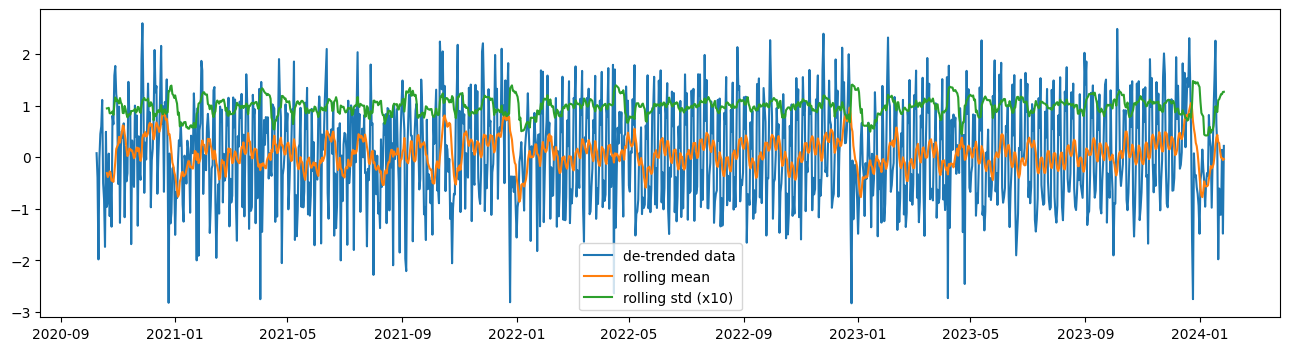

In [9]:
# Detrending
y_float = y.apply(float)

y_detrend = (y_float - y_float.rolling(window=12).mean()) / y_float.rolling(window=12).std()

test_stationarity(y_detrend, 'de-trended data')
ADF_test(y_detrend, 'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -9.405
P-value = 0.000
Critical values :
	1%: -3.4358991704737245 - The data is  stationary with 99% confidence
	5%: -2.863990392722102 - The data is  stationary with 95% confidence
	10%: -2.568074638859274 - The data is  stationary with 90% confidence


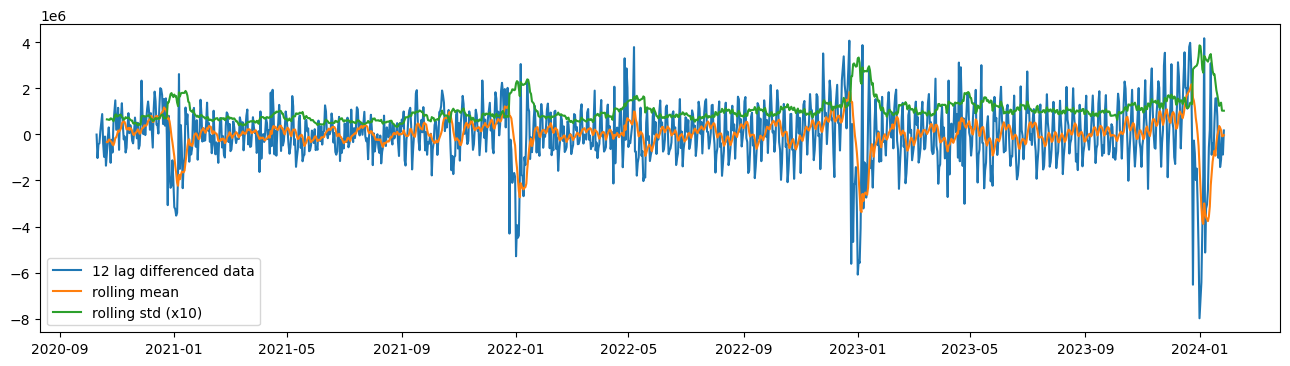

In [10]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -13.094
P-value = 0.000
Critical values :
	1%: -3.435951457295239 - The data is  stationary with 99% confidence
	5%: -2.8640134598745144 - The data is  stationary with 95% confidence
	10%: -2.5680869238074364 - The data is  stationary with 90% confidence


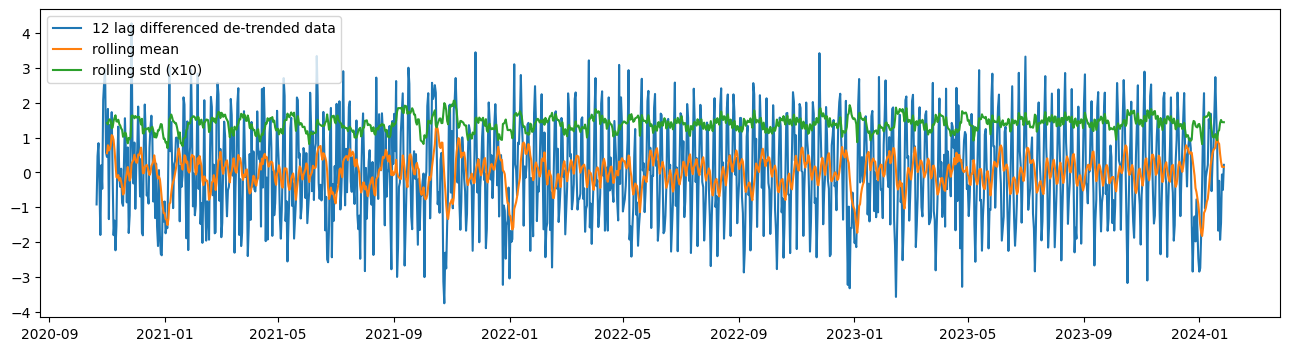

In [11]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [13]:

y_to_train = y[:'2022-12-31'] # dataset to train
y_to_val = y['2023-01-01':] # last X months for test  
predict_date = len(y) - len(y[:'2023-01-01']) # the number of data point
#y_float = y.astype(float)
#print(exog)
#exog=exog['campaign']
exog=exog['2020-09-28':]
#exog=exog['2021-06-01':]
exog_to_train=exog[:'2022-12-31']
exog_to_val=exog['2023-01-01':]

# print(len(y_to_val))
# print(exog_to_val)
# print(type(y_to_val))
# print(y.index.equals(exog.index))
exog=exog.drop(columns=['weekend'],axis=1)
print(len(exog))
print(len(y))
print(max(y.index))
print(min(y.index))
print(max(exog.index))
print(min(exog.index))

1217
1217
2024-01-27 00:00:00
2020-09-28 00:00:00
2024-01-27 00:00:00
2020-09-28 00:00:00


In [15]:
# #This is the old grid search
# def sarima_grid_search(y, seasonal_period):
#     # Define the range for p, d, q
#     p = d = q = range(0, 2)  # Keep these ranges small
#     pdq = list(itertools.product(p, d, q))
#     seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
#     print(pdq)
#     print(seasonal_pdq)
#     wb = load_workbook('seasonalparams.xlsx')
#     sheet = wb.active
#     mini = float('+inf')
#     print(mini)
#     param_mini, param_seasonal_mini = None, None  # Initialize these variables
#     iteration = 0
#     row=1
#     #for param in pdq:
#     for x in range(64):
#         print(x)
#         #for param_seasonal in seasonal_pdq:
#         row+=1
#         iteration += 1  # Increment iteration counter
#         start_time = time.time()  # Start timing this iteration
#         try:
#             param=ast.literal_eval(sheet.cell(row=row, column=1).value)
#             param_seasonal=ast.literal_eval(sheet.cell(row=row, column=2).value)
# #             print(type(param))
# #             print(param)
# #             print(type(param_seasonal))
# #             print(param)
#             #sheet.cell(row=row, column=2).value = str(param_seasonal)
            

#               #  Save the workbook to apply the changes
                
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                                 order=param,
#                                                 seasonal_order=param_seasonal,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)

#             results = mod.fit()
#             sheet.cell(row=row, column=3).value=results.aic
#             if results.aic < mini:
#                 mini = results.aic
#                 param_mini = param
#                 param_seasonal_mini = param_seasonal

#         except Exception as e:
#             print(f"An error occurred: {e}")  # To understand what errors are occurring
#             continue
#         finally:
#             end_time = time.time()  # End timing this iteration
#             duration = end_time - start_time  # Calculate duration
#             sheet.cell(row=row, column=4).value=duration
#             print(f'Iteration {iteration}: SARIMA{param}x{param_seasonal} took {duration:.2f} seconds')
#             wb.save('seasonalparams.xlsx')
    
    

#     if param_mini is not None and param_seasonal_mini is not None:
#         print(f'The set of parameters with the minimum AIC is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{mini}')
#         #print("hi")
#     else:
#         print("No suitable model found")
    
# sarima_grid_search(y,365)


In [16]:
# New gridsearch
# def sarima_grid_search(y, seasonal_period):
#     p = d = q = range(0, 2)  # Define the range for p, d, q
#     pdq = list(itertools.product(p, d, q))
#     seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
#     wb = load_workbook('seasonalparams.xlsx')
#     sheet = wb.active

#     # Find the last row in column 4 that is populated
#     last_row = 1
#     for row in range(sheet.max_row, 0, -1):
#         if sheet.cell(row=row, column=4).value is not None:
#             last_row = row + 1
#             break
#     print(last_row)
#     mini = float('+inf')
#     param_mini, param_seasonal_mini = None, None
#     iteration = 0

#     # Start the loop from the last populated row in column 4
#     for row in range(last_row, last_row + 64):  # Adjust 64 based on your requirement
#         iteration += 1
#         start_time = time.time()
#         try:
#             param = ast.literal_eval(sheet.cell(row=row, column=1).value)
#             param_seasonal = ast.literal_eval(sheet.cell(row=row, column=2).value)

#             mod = sm.tsa.statespace.SARIMAX(y,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()

#            # Example of handling results
#             results_aic = results.aic
#             sheet.cell(row=row, column=3).value = results_aic
#             if results_aic < mini:
#                 mini = results_aic
#                 param_mini = param
#                 param_seasonal_mini = param_seasonal

#         except Exception as e:
#             print(f"An error occurred: {e}")
#             continue
#         finally:
#             end_time = time.time()
#             duration = end_time - start_time
#             sheet.cell(row=row, column=4).value = duration
#             print(f'Iteration {iteration}: SARIMA{param}x{param_seasonal} took {duration:.2f} seconds')
#             print(f'param: {param}     SParam: {param_seasonal}     AIC: {sheet.cell(row=row, column=3).value}     Time: { sheet.cell(row=row, column=4).value}' )
#             wb.save('seasonalparams.xlsx')

#     #wb.save('seasonalparams.xlsx')

#     if param_mini is not None and param_seasonal_mini is not None:
#         print(f'The set of parameters with the minimum AIC is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{mini}')
#     else:
#         print("No suitable model found")

# # Remember to define 'y' and ensure you have the correct imports and setup for SARIMAX fitting
# sarima_grid_search(y, 365)

                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
campaign           3.476e+05   1.64e+05      2.118      0.034     2.6e+04    6.69e+05
is_public_holiday -2.972e+06    7.2e+04    -41.257      0.000   -3.11e+06   -2.83e+06
sin_1              5.797e+05   3.14e+04     18.480      0.000    5.18e+05    6.41e+05
cos_1              8.149e+04   2.96e+04      2.750      0.006    2.34e+04     1.4e+05
sin_2              3.305e+05   1.29e+05      2.552      0.011    7.67e+04    5.84e+05
cos_2             -3.592e+05   1.33e+05     -2.703      0.007    -6.2e+05   -9.87e+04
sin_3             -3.188e+05    2.6e+05     -1.228      0.220   -8.28e+05     1.9e+05
cos_3             -2.972e+05   2.43e+05     -1.221      0.222   -7.74e+05     1.8e+05
sin_4             -1.837e+05   2.35e+05     -0.783      0.433   -6.43e+05    2.76e+05
cos_4              1.685e+05   2.15e+05      0.784    

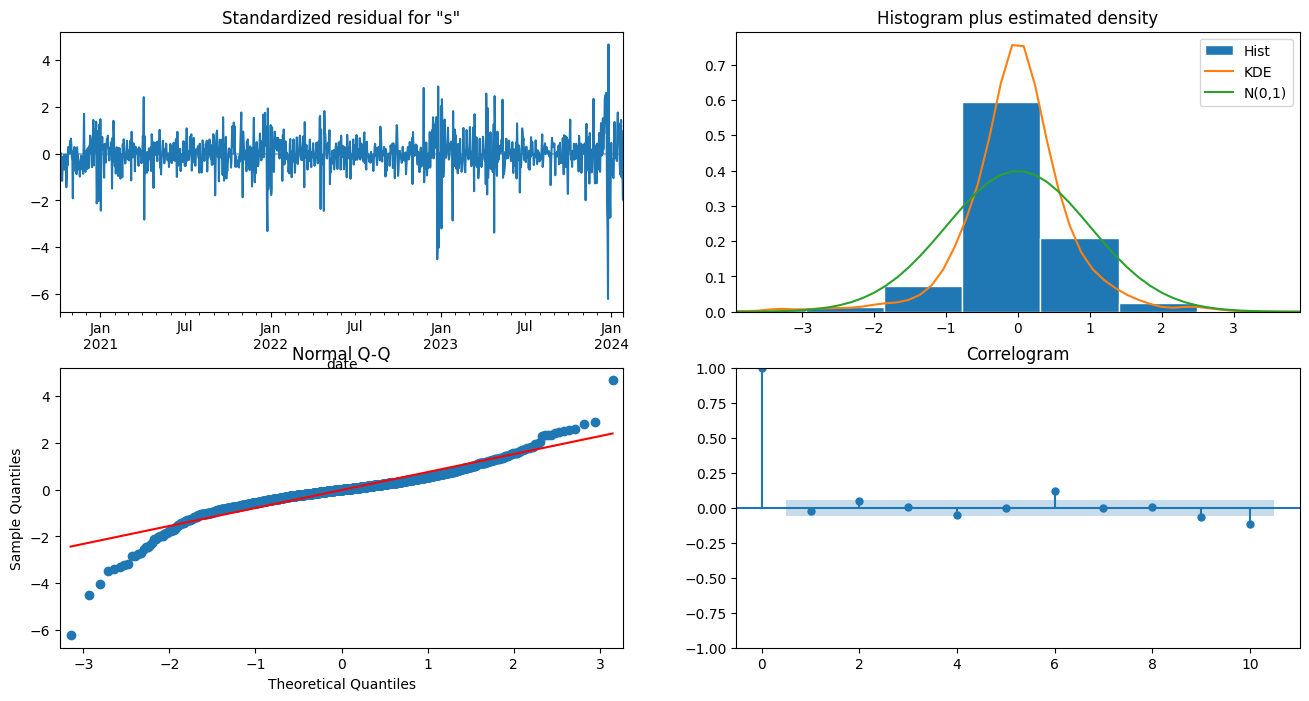

3.6772210597991943  OneStepAheadForecast has finished
The Mean Squared Error of our one-step ahead forecasts is 347477292752.68


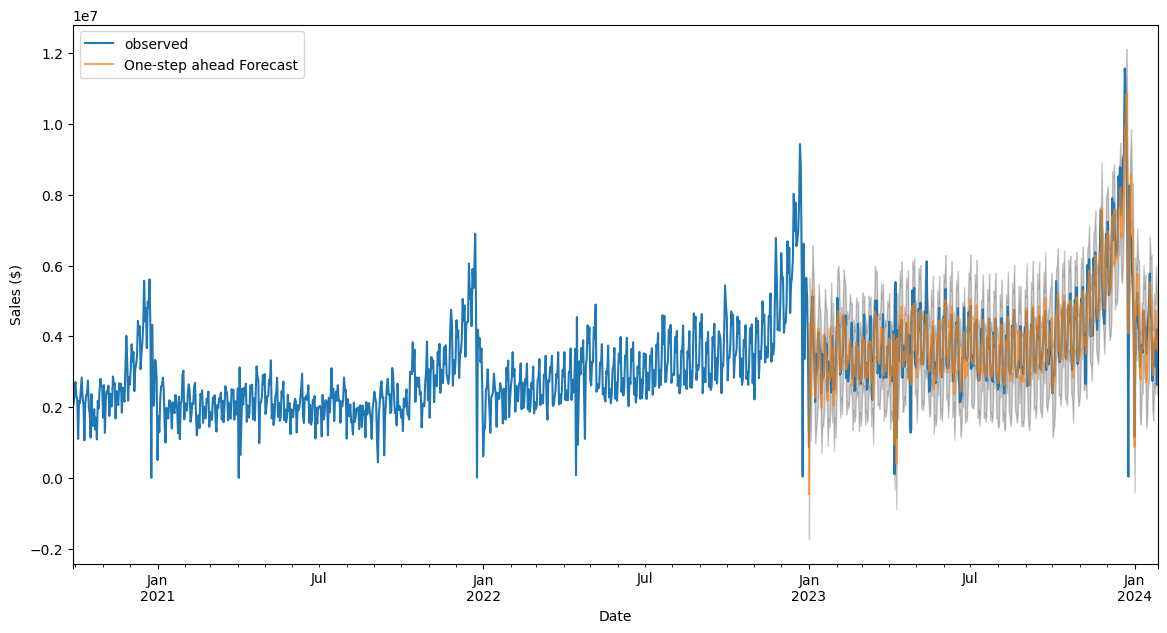

MSE: 347,477,292,752.68
RMSE: 589,472.05
MAE: 379,981.23
MAPE: 44.09%
R^2: 0.82
The Mean Absolute Percentage Error of our one-step ahead forecasts is 44.09%
The model took 4.15 seconds to run
{'coefficient': 347635.4076851905, 'standard_error': 164120.68845474726, 'confidence_interval': array([ 25964.76919597, 669306.04617441])}


C:\Users\dharmickmehta\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [17]:
def sarima_eva(y,exog, order, seasonal_order, seasonal_period, pred_date, y_to_test,exog_to_test):
    # fit the model
    mod = sm.tsa.statespace.SARIMAX(endog=y,
                                    exog=exog,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_invertibility=False
                                      )
    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # One-step ahead forecast
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False,exog=exog_to_test)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    end_time1 = time.time()
    duration1 = end_time1 - start_time
    print(duration1,' OneStepAheadForecast has finished')
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    
    print('The Mean Squared Error of our one-step ahead forecasts is {}'.format(round(mse, 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales ($)')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_to_test, y_forecasted)

    # Calculate RMSE
    rmse = mean_squared_error(y_to_test, y_forecasted, squared=False)

    # Calculate MAE
    mae = mean_absolute_error(y_to_test, y_forecasted)

    # Calculate MAPE - Handling division by zero if y contains zeros
    mape = np.mean(np.abs((y_to_test - y_forecasted) / y_to_test)) * 100# if np.all(y) else float('inf')
    y_to_test.to_clipboard()
    # Calculate R^2
    r2 = r2_score(y_to_test, y_forecasted)
    print('MSE: {:,.2f}'.format(mse))
    print('RMSE: {:,.2f}'.format(rmse))
    print('MAE: {:,.2f}'.format(mae))
    print('MAPE: {:.2f}%'.format(mape))  # Percentage values don't typically include commas
    print('R^2: {:.2f}'.format(r2))

    # Calculate MAPE for one-step ahead
    mape_one_step = np.mean(np.abs(y_forecasted - y_to_test) / y_to_test) * 100
    print('The Mean Absolute Percentage Error of our one-step ahead forecasts is {:.2f}%'.format(mape_one_step))

    # Dynamic forecast
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True,exog=exog_to_test)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    #print('The Mean Squared Error of our dynamic forecasts is {}'.format(round(mse_dynamic, 2)))

#     ax = y.plot(label='observed')
#     y_forecasted_dynamic.plot(ax=ax, label='Dynamic Forecast', alpha=.7, figsize=(14, 7))
#     ax.fill_between(pred_dynamic_ci.index,
#                     pred_dynamic_ci.iloc[:, 0],
#                     pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Sales ($)')
#     plt.legend()
#    # plt.show()

    # Calculate MAPE for dynamic
#     mse = mean_squared_error(y_to_test, y_forecasted_dynamic)

#     # Calculate RMSE
#     rmse = mean_squared_error(y_to_test, y_forecasted_dynamic, squared=False)

#     # Calculate MAE
#     mae = mean_absolute_error(y_to_test, y_forecasted_dynamic)

#     # Calculate MAPE - Handling  by zero if y contains zeros
#     mape = np.mean(np.abs((y_to_test - y_forecasted_dynamic) / y_to_test)) * 100 if np.all(y) else float('inf')

#     # Calculate R^2
#     r2 = r2_score(y_to_test, y_forecasted_dynamic)
#     print('MSE: {:,.2f}'.format(mse))
#     print('RMSE: {:,.2f}'.format(rmse))
#     print('MAE: {:,.2f}'.format(mae))
#     print('MAPE: {:.2f}%'.format(mape))  # Percentage values don't typically include commas
#     print('R^2: {:.2f}'.format(r2))
    df_forecasts = pd.DataFrame({'Actual Sales': y_to_test,
                                 'One-step Ahead Forecast': y_forecasted,
                                 'Dynamic Forecast': y_forecasted_dynamic})
    df_forecasts.index = y_to_test.index  # Assuming y_to_test is a Series with a DateTimeIndex
    coeff_details = {}
    # Check if the variable is in the model parameters
    variable_name='campaign'
    if variable_name in results.params.index:
        coeff_details['coefficient'] = results.params[variable_name]
        coeff_details['standard_error'] = results.bse[variable_name]
        coeff_details['confidence_interval'] = results.conf_int().loc[variable_name].values
    else:
        print(f"Variable '{variable_name}' not found in the model.")
    model_summary = pd.DataFrame(results.summary().tables[1])
    new_header = model_summary.iloc[0] #grab the first row for the header
    model_summary= model_summary[1:] #take the data less the header row
    model_summary.columns = new_header 
    
    

    return results, df_forecasts,coeff_details,model_summary

# Assume y is defined and y_to_val contains the actual values to validate against
#model = sarima_eva(y, (0, 0, 0), (0, 1, 1, 52), 52, '2023-05-07', y_to_val)

#SARIMA(0, 1, 1)x(1, 1, 1, 52)
start_time = time.time()
#print(y.to_string())
model, df_forecasts, campaign_coeff_details, model_summary  = sarima_eva(y,exog, (1, 1, 1), (1, 1, 1, 7), 7, '2023-01-01', y_to_val,exog_to_val)
end_time = time.time()
duration = end_time - start_time
print(f'The model took {duration:.2f} seconds to run')
# print(len(exog_to_val))
# print(y.index.max())
# print(y.index.min())
# print(exog.index.max())
# print(exog.index.min())
#model, df_forecasts = sarima_eva(y, (0, 1, 1), (1, 1, 1, 365), 365, '2023-05-07', y_to_val)
print(campaign_coeff_details)


In [18]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    
    return (final_table)
#final_table = forecast(model,52,y)
#final_table.head()


In [19]:
print(df_forecasts)
df_forecasts.to_csv('forecast_daily_with_exog2_fourier.csv')

               Actual Sales  One-step Ahead Forecast  Dynamic Forecast
date                                                                  
2023-01-01  862599.26000000         -452821.99543813  -452821.99543813
2023-01-02 2285411.02000000         4364946.25818961  3650403.67356695
2023-01-03 3848280.17000000         2337308.15095847  2946645.11119906
2023-01-04 4654645.35000000         3923855.50507545  3468118.81100322
2023-01-05 5127761.60000000         5298508.90265134  4589965.00353004
...                     ...                      ...               ...
2024-01-23 3290581.91000000         3948868.39549131 -3041778.90199131
2024-01-24 3145283.13000000         3653316.81780636 -2534146.63300536
2024-01-25 4189974.32000000         4709153.90499989 -1313209.31498315
2024-01-26 2628437.30000000         3909711.77105289 -1705843.36810151
2024-01-27 4215693.07000000         3592087.01579796 -1827473.10675552

[392 rows x 3 columns]


In [20]:
#Calculating camapign incrementality for 2023
# coeff_details['coefficient'] = results.params[variable_name]
# coeff_details['standard_error'] = results.bse[variable_name]
# coeff_details['confidence_interval'] = results.conf_int().loc[variable_name].values

incremental_revenue= campaign_coeff_details['coefficient']*exog.loc['2023-01-01':'2023-12-31', 'campaign'].sum()
incremental_revenue_lower_bound= campaign_coeff_details['confidence_interval'][0]*exog.loc['2023-01-01':'2023-12-31', 'campaign'].sum()
incremental_revenue_upper_bound= campaign_coeff_details['confidence_interval'][1]*exog.loc['2023-01-01':'2023-12-31', 'campaign'].sum()
print(incremental_revenue_lower_bound)
sales_2023=data.loc['2023-01-01':'2023-12-31', 'sales'].sum()
bl_customers_sales=233664921 #this is from Ryan, The total BL customer sales when redeeming rewards


incremental_revenue_over_total_sales = (incremental_revenue/sales_2023)*100
incremental_revenue_lower_bound_over_total_sales = (incremental_revenue_lower_bound/sales_2023)*100
incremental_revenue_upper_bound_over_total_sales = (incremental_revenue_upper_bound/sales_2023)*100

incremental_revenue_over_bl_Customers=(incremental_revenue/bl_customers_sales)*100
incremental_revenue_lower_bound_over_bl_Customers = (incremental_revenue_lower_bound/bl_customers_sales)*100
incremental_revenue_upper_bound_over_bl_Customers = (incremental_revenue_upper_bound/bl_customers_sales)*100

print(f'Incremental Revenue in 2023: $ {incremental_revenue:,.0f}')
print(f'Actual Sales in 2023: $ {sales_2023:,.0f}')
print(f'Incremental Revenue as a percentage: {incremental_revenue_over_total_sales:,.2f} %')
print(f'Incremental Revenue as a percentage of BL Customer Sales: {incremental_revenue_over_bl_Customers:,.2f} %') #This is a stretch
# print(campaign_coeff_details)
# print(campaign_coeff_details['confidence_interval'][0])

print('\n')
print('Lower Bound')
print(f'Incremental Revenue in 2023: $ {incremental_revenue_lower_bound:,.0f}')
print(f'Actual Sales in 2023: $ {sales_2023:,.0f}')
print(f'Incremental Revenue as a percentage: {incremental_revenue_lower_bound_over_total_sales:,.2f} %')
print(f'Incremental Revenue as a percentage of BL Customer Sales: {incremental_revenue_lower_bound_over_bl_Customers:,.2f} %') #This is a stretch
print('\n')

print('Upper Bound')
print(f'Incremental Revenue in 2023: $ {incremental_revenue_upper_bound:,.0f}')
print(f'Actual Sales in 2023: $ {sales_2023:,.0f}')
print(f'Incremental Revenue as a percentage: {incremental_revenue_upper_bound_over_total_sales:,.2f} %')
print(f'Incremental Revenue as a percentage of BL Customer Sales: {incremental_revenue_upper_bound_over_bl_Customers:,.2f} %') #This is a stretch


print('\n')

# Save model output in a file for posterity
print(model_summary)
sales_2022=data.loc['2022-01-01':'2022-12-31', 'sales'].sum()
sales_2021=data.loc['2021-01-01':'2021-12-31', 'sales'].sum()
print(f'Actual Sales in 2021: $ {sales_2021:,.0f}')
print(f'Actual Sales in 2022: $ {sales_2022:,.0f}')
output_file_path = f'SarimaxFourier/model_output_{K}.xlsx'
with pd.ExcelWriter(output_file_path) as writer:
    # Write the summary to the 'model_summary' sheet
    # Convert the summary to a string, then write to Excel
    summary_str = model.summary().as_text()
    summary_lines = summary_str.split('\n')
    summary_data = [line.split() for line in summary_lines]
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, index=False, header=False, sheet_name='model_summary')

    # Write the 'df' DataFrame to the 'df data' sheet
    df.to_excel(writer, sheet_name='df data')

print(summary_str)

# Save the workbook
writer.save()
sales_2022=data.loc['2022-01-01':'2022-12-31', 'sales'].sum()
sales_2021=data.loc['2021-01-01':'2021-12-31', 'sales'].sum()
print(sales_2021)
print(sales_2022)

4258222.148138627
Incremental Revenue in 2023: $ 57,012,207
Actual Sales in 2023: $ 1,453,804,252
Incremental Revenue as a percentage: 3.92 %
Incremental Revenue as a percentage of BL Customer Sales: 24.40 %


Lower Bound
Incremental Revenue in 2023: $ 4,258,222
Actual Sales in 2023: $ 1,453,804,252
Incremental Revenue as a percentage: 0.29 %
Incremental Revenue as a percentage of BL Customer Sales: 1.82 %


Upper Bound
Incremental Revenue in 2023: $ 109,766,192
Actual Sales in 2023: $ 1,453,804,252
Incremental Revenue as a percentage: 7.55 %
Incremental Revenue as a percentage of BL Customer Sales: 46.98 %


0                            coef    std err          z   P>|z|     [0.025   
1            campaign   3.476e+05   1.64e+05      2.118   0.034    2.6e+04  \
2   is_public_holiday  -2.972e+06    7.2e+04    -41.257   0.000  -3.11e+06   
3               sin_1   5.797e+05   3.14e+04     18.480   0.000   5.18e+05   
4               cos_1   8.149e+04   2.96e+04      2.750   0.006   2.34e

OSError: Cannot save file into a non-existent directory: 'SarimaxFourier'

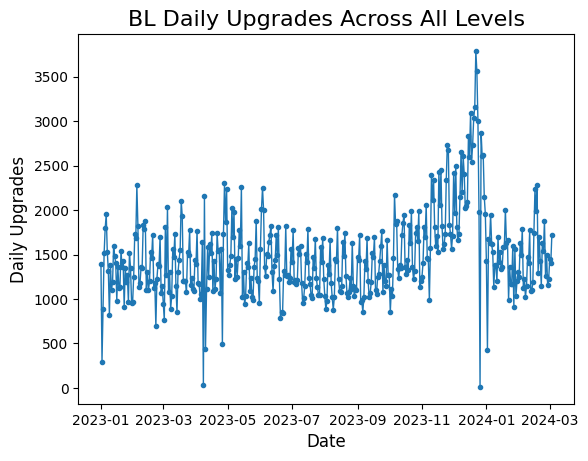

<Figure size 2000x100100 with 0 Axes>

['2023-01-01', '2023-10-03']
['2023-10-04', '2023-10-18']


C:\Users\dharmickmehta\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


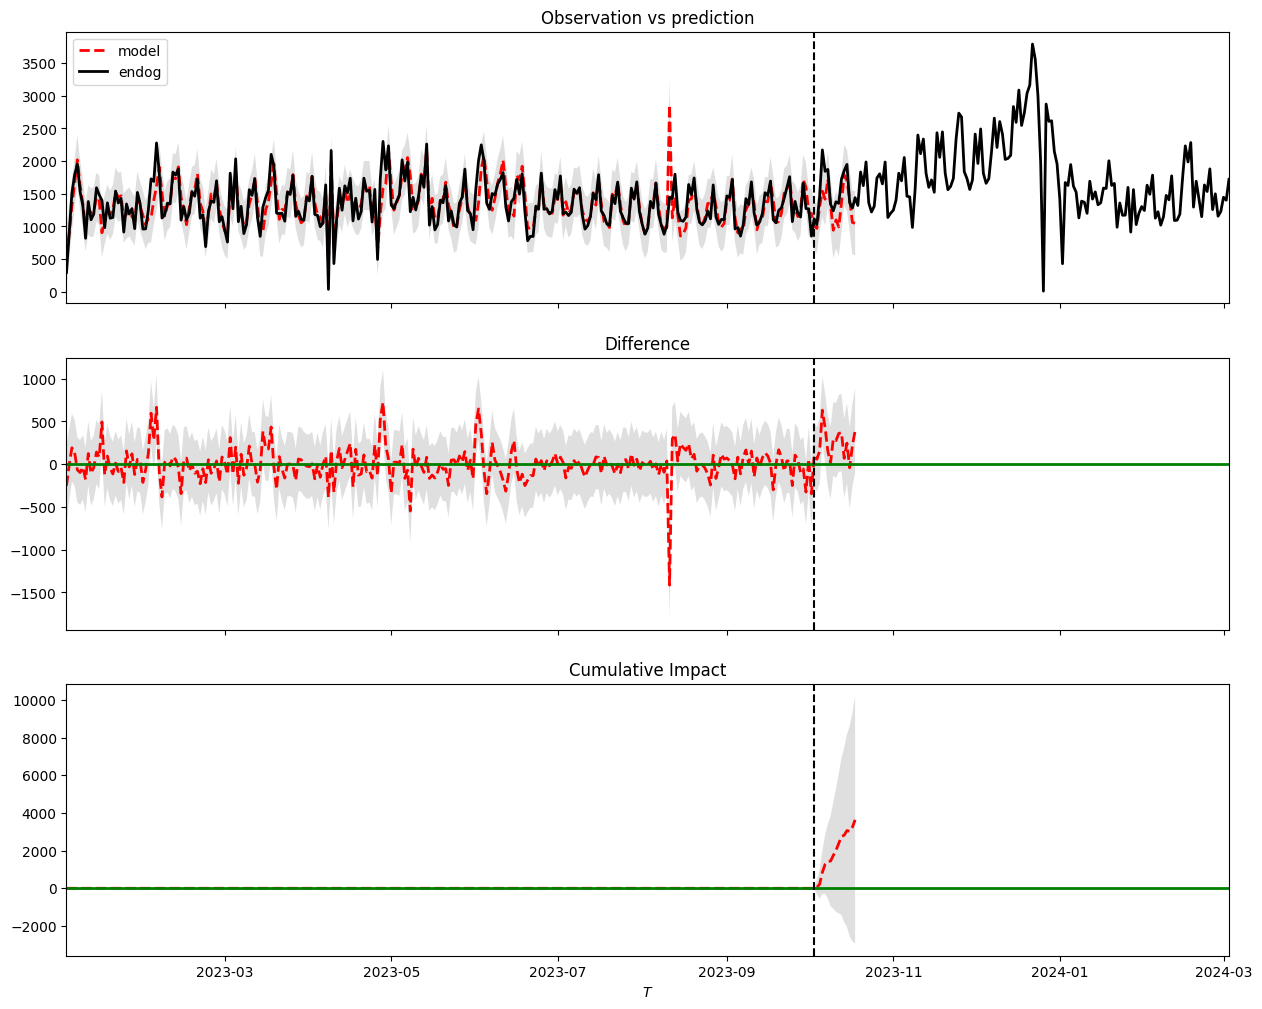

                                Average       Cumulative
Actual                             1553            23300
Predicted                          1311            19668
95% CI                      [874, 1748]   [13114, 26223]
                                                        
Absolute Effect                     242             3631
95% CI                      [679, -194]   [10185, -2923]
                                                        
Relative Effect                   18.5%            18.5%
95% CI                  [51.8%, -14.9%]  [51.8%, -14.9%]
                                                        
P-value                            0.0%                 
Prob. of Causal Effect           100.0%                 


In [ ]:
from causalimpact import CausalImpact
import pandas as pd
import matplotlib.pyplot as plt


# Assuming you have a DataFrame `df` with a DateTime index and a 'sales' column
# Here's how you might construct such a DataFrame for demonstration:
#df = pd.DataFrame({'sales': [your_sales_data_here]}, index=pd.date_range(start="2023-01-01", periods=your_data_length))
df=pd.read_csv(r'C:\Users\dharmickmehta\OneDrive - COSMETICS CUBED PTY LTD\Tiering2023.csv')
# Define the period before and after the event


# Since we don't have the actual file, we will simulate reading your Excel data.
# You can replace this part with `df = pd.read_excel('path_to_your_file.xlsx')`
# to load your data directly from the Excel file.
# data = {
#     'start_date': ['8/06/2023', '10/06/2023', '24/09/2023', '15/02/2023'],
#     'upgrades': [1479, 1722, 1761, 1743],
#     'maintain': [634, 955, 1156, 4165],
#     'downgrades': [1348, 1911, 2254, 3078]
# }

# df = pd.DataFrame(data)
df['start_date'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y')
df.set_index('start_date', inplace=True)
df.sort_index(inplace=True)

fig, ax = plt.subplots()  # Create a figure containing a single axes.
plt.plot(df.index,df['upgrades'],marker='.', linestyle='-', linewidth=1, label='Upgrades')
#ax.plot(df.index,df['maintain'], linestyle='-', linewidth=3, label='Maintain')
# Sort the DataFrame by the index to ensure the time series is in correct order
plt.title('BL Daily Upgrades Across All Levels',fontsize=16)
plt.ylabel('Daily Upgrades',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.figure(figsize=(20,1001))
plt.show()

plt.show()

# Assume the event date is October 4th, 2023
# If the actual event date is different, update this accordingly.
event_date = '2023-10-04'

# Define the pre-intervention and post-intervention periods
# The pre_period and post_period should be in the format (start_date, end_date)
#                 Using the whole dataset
# pre_period = [df.index.min().strftime('%Y-%m-%d'), (pd.to_datetime(event_date) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')]
# post_period = [event_date, df.index.max().strftime('%Y-%m-%d')]
#                 Using whole pre-period and 2 weeks after
pre_period = [df.index.min().strftime('%Y-%m-%d'), (pd.to_datetime(event_date) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')]
post_period = [event_date, (pd.to_datetime(event_date) + pd.Timedelta(weeks=2)).strftime('%Y-%m-%d')]
# pre_period = [(pd.to_datetime(event_date) - pd.Timedelta(weeks=2)).strftime('%Y-%m-%d'), 
#               (pd.to_datetime(event_date) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')]
# post_period = [(pd.to_datetime(event_date) + pd.Timedelta(days=0)).strftime('%Y-%m-%d'), 
#                (pd.to_datetime(event_date) + pd.Timedelta(weeks=2)).strftime('%Y-%m-%d')]

print(pre_period)
print(post_period)
# Run the CausalImpact analysis on the 'upgrades' column
ci = CausalImpact(df, pre_period, post_period)
ci.run()
ci.plot()
ci.summary()